In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import keras_tuner as kt

# Modelo
# Cargar dataset
df = pd.read_csv('../datasetintermedio.csv')
df_not_outliers = df.drop(columns=['es_outlier'])

# Separar X e y
y = df['Precio_usd']
X = df.drop(columns=['Precio_usd'])

X_sin_outliers = df_not_outliers.drop(columns=['Precio_usd'])

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_sin_outliers = scaler.fit_transform(X_sin_outliers)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Split sin outliers
X_train_sin_outliers, X_test_sin_outliers, y_train_sin_outliers, y_test_sin_outliers = train_test_split(
    X_scaled_sin_outliers, y, test_size=0.2, random_state=42
)


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mae']
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner.search(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 13s]
val_mae: 4608.48876953125

Best val_mae So Far: 4289.1953125
Total elapsed time: 00h 02m 24s


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
# Modelo
def build_model2(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train_sin_outliers.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mae']
    )
    return model

# Tuner
tuner2 = kt.RandomSearch(
    build_model2,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar mejores hiperparámetros
tuner2.search(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Mejor modelo
best_model_sinOutlier = tuner2.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 15s]
val_mae: 4288.77734375

Best val_mae So Far: 4246.18359375
Total elapsed time: 00h 02m 24s


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)
history_sin_Outliers = best_model_sinOutlier.fit(X_train_sin_outliers, y_train_sin_outliers, validation_split=0.2, epochs=100, batch_size=32, verbose=1)


Epoch 1/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - loss: 5342.6772 - mae: 5249.2188 - val_loss: 4443.2905 - val_mae: 4350.5737
Epoch 2/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 5114.8188 - mae: 5021.9248 - val_loss: 4528.9961 - val_mae: 4435.5298
Epoch 3/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 5168.8042 - mae: 5074.9722 - val_loss: 4538.3042 - val_mae: 4442.9517
Epoch 4/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 5278.6460 - mae: 5182.9790 - val_loss: 4451.2202 - val_mae: 4354.7119
Epoch 5/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 5035.4727 - mae: 4938.6924 - val_loss: 5306.7427 - val_mae: 5209.2949
Epoch 6/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 5071.0469 - mae: 4973.2725 - val_loss: 4654.6865 - val_mae: 4556.3530
Epoch 7/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 4987.5225 - mae: 4888.8604 - val_loss: 4652.5640 - val_mae: 4553.1714
Epoch 8/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 5159.7

In [5]:
y_pred = best_model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")


y_pred_sin_outliers = best_model_sinOutlier.predict(X_test_sin_outliers).flatten()
mae_sin_outliers = mean_absolute_error(y_test_sin_outliers, y_pred_sin_outliers)
rmse_sin_outliers = np.sqrt(mean_squared_error(y_test_sin_outliers, y_pred_sin_outliers))
r2_sin_outliers = r2_score(y_test_sin_outliers, y_pred_sin_outliers)
mape_sin_outliers = np.mean(np.abs((y_test_sin_outliers - y_pred_sin_outliers) / y_test_sin_outliers)) * 100
print(f"\n--- MÉTRICAS SIN OUTLIERS ---")
print(f"MAE: ${mae_sin_outliers:,.0f}")
print(f"RMSE: ${rmse_sin_outliers:,.0f}")
print(f"R2: {r2_sin_outliers:.3f}")
print(f"MAPE: {mape_sin_outliers:.2f}%")

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step

--- MÉTRICAS ---
MAE: $4,423
RMSE: $11,020
R2: 0.726
MAPE: 40.81%
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step

--- MÉTRICAS SIN OUTLIERS ---
MAE: $4,815
RMSE: $27,124
R2: -0.661
MAPE: 41.55%


In [6]:
# Asumiendo que ya tenés y_test (valores reales) y y_pred (predicciones del modelo)
df_resultados = pd.DataFrame({
    'Precio_real': y_test,
    'Precio_predicho': y_pred
})

# Error absoluto
df_resultados['Error_absoluto'] = np.abs(df_resultados['Precio_real'] - df_resultados['Precio_predicho'])

# Crear segmentos (cuartiles) por precio real
df_resultados['Segmento_precio'] = pd.qcut(df_resultados['Precio_real'], q=4, labels=['Bajo', 'Medio-bajo', 'Medio-alto', 'Alto'])

# Calcular métricas por segmento
resumen_segmentos = df_resultados.groupby('Segmento_precio').agg({
    'Precio_real': ['count', 'mean'],
    'Error_absoluto': ['mean', 'median', 'max']
}).round(0)

# Mostrar resumen
print(resumen_segmentos)

                Precio_real          Error_absoluto                  
                      count     mean           mean  median       max
Segmento_precio                                                      
Bajo                    924  12905.0         2508.0  1389.0   95575.0
Medio-bajo              908  20183.0         2774.0  2031.0   23112.0
Medio-alto              906  28109.0         3106.0  2596.0   34763.0
Alto                    913  51609.0         9309.0  4102.0  238844.0


/var/folders/h8/075vvj7s65sgq5xnd_m0zfkc0000gn/T/ipykernel_6498/3629614219.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_segmentos = df_resultados.groupby('Segmento_precio').agg({


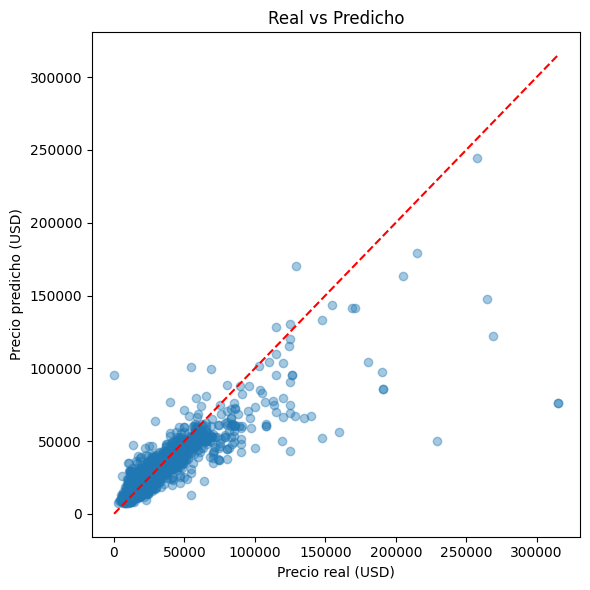

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Precio real (USD)")
plt.ylabel("Precio predicho (USD)")
plt.title("Real vs Predicho")
plt.tight_layout()
plt.show()

In [8]:
dataset1 = pd.read_csv('../dataset_basico.csv')

X1, y1 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X1)

# Split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y1, test_size=0.2, random_state=42)


In [9]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train1.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mae']
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner.search(X_train1, y_train1, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 13s]
val_mae: 3102.865478515625

Best val_mae So Far: 3092.129150390625
Total elapsed time: 00h 02m 08s


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
y_pred = best_model.predict(X_test1).flatten()

mae = mean_absolute_error(y_test1, y_pred)
rmse = np.sqrt(mean_squared_error(y_test1, y_pred))
r2 = r2_score(y_test1, y_pred)
mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step

--- MÉTRICAS ---
MAE: $3,051
RMSE: $4,766
R2: 0.799
MAPE: 12.64%


In [11]:
# Recuperar los mejores hiperparámetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model1 = build_model(best_hp)
history1 = model1.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=50,
    batch_size=32,
    verbose=1
)



Epoch 1/50


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - loss: 17687.5605 - mae: 17681.9785 - val_loss: 3894.8997 - val_mae: 3879.7368
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 5202.0527 - mae: 5186.2432 - val_loss: 3683.1960 - val_mae: 3665.6689
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 4679.1250 - mae: 4661.1963 - val_loss: 3549.9055 - val_mae: 3530.3313
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 4533.4531 - mae: 4513.6118 - val_loss: 3612.9172 - val_mae: 3592.1777
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 4346.1519 - mae: 4325.0107 - val_loss: 3265.1885 - val_mae: 3243.0989
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 4320.9199 - mae: 4298.4517 - val_loss: 3332.2400 - val_mae: 3308.7888
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 4210.7148 - mae: 4187.0078 - val_loss: 3314.5122 - val_mae: 3290.0955
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 4206.6567 - mae: 4181.9

In [ ]:
# Recuperar los mejores hiperparámetros
best_hp2 = tuner2.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model2 = build_model2(best_hp2)
history2 = model2.fit(
    X_train_sin_outliers, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_8" is incompatible with the layer: expected axis -1 of input shape to have value 56, but received input with shape (None, 93)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 93), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
dataset1 = pd.read_csv('../dataset_final.csv')

X2, y2 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled2 = scaler.fit_transform(X2)

# Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y2, test_size=0.2, random_state=42)


In [ ]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train2.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mae']
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner.search(X_train2, y_train2, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]


In [ ]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model3 = build_model(best_hp3)
history3 = model3.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=50,
    batch_size=32,
    verbose=1
)

NameError: name 'history2' is not defined

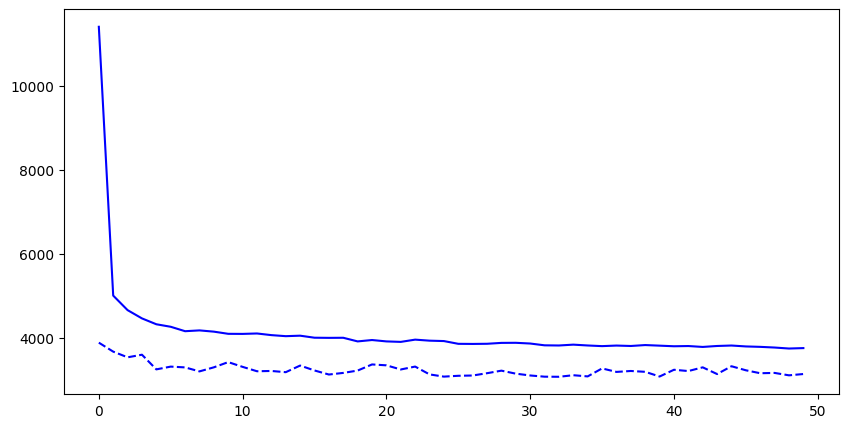

In [13]:

plt.figure(figsize=(10, 5))
plt.plot(history1.history['mae'], label='Entrenamiento dataset básico',color='blue')
plt.plot(history1.history['val_mae'], label='Validación dataset básico',color='blue', linestyle='--')
plt.plot(history2.history['mae'], label='Entrenamiento dataset intermedio',color='orange')
plt.plot(history2.history['val_mae'], label='Validación dataset intermedio', linestyle='--', color='orange')
plt.plot(history3.history['mae'], label='Entrenamiento dataset final',color='green')
plt.plot(history3.history['val_mae'], label='Validación dataset final', linestyle='--', color='green')
plt.title('MAE vs. Epochs')
plt.xlabel('Época')
plt.ylabel('Error absoluto medio (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
